In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
#plt.rcParams["figure.figsize"] = (12,4)

In [10]:
def esprit_on_band(RI, fs, lowcut, highcut, poles, order=5, len_esprit=512*7, plot_result=False, number_of_max = 4, Nfft=100000) :
    """
    Cette fonction utilise l'algorithme ESPRIT sur une bande de fréquence particulière.
    Il calcul aussi la réponse en fréquence, et les amplitudes de cette réponses aux fréquence trouvées par ESPRIT.

    ## Inputs
    - `RI` : réponse impulsionnelle d'entrée
    - `fs` : fréquence d'échantillonnage
    - `lowcut` : fréquence de coupure basse du filtre à appliquer
    - `highcut` : fréquence de coupure haute du filtre à appliquer
    - `poles` : nombre de pôles calculés par ESPRIT
    - `order` : ordre du filtre butterworth utilisé
    - `len_esprit` : longueur de la portion ud signal donnée à ESPRIT
    - `plot_result` : trace la réponse en fréquence avec les fréquences trouvées par ESPRIT si `True`
    - `Nfft` : nombre de points pour la FFT

    ## Outputs
    - `freq_amp_sorted` : arrayLike, liste des fréquences trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    - `delta_amp_sorted` : arrayLike, liste des amortissements trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    """

    RI_filtered = mm.bandpass_filter(RI, lowcut, highcut, fs, order=order)
    fk, deltak = mm.ESPRIT(RI_filtered[500:500 + len_esprit], len_esprit//2, poles, return_pos=True)

    Y = np.fft.rfft(RI_filtered[500:500 + len_esprit], Nfft)
    fy = np.fft.rfftfreq(Nfft,1/fs)

    #Calcul des amplitudes de la réponse en fréquences aux fréquences trouvées par ESPRIT
    amp = np.zeros(len(fk))
    for i in range(len(fk)) :
        fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
        amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
    freq_amp_sorted = fk[amp.argsort()[-number_of_max:][::-1]]*fs
    delta_amp_sorted = deltak[amp.argsort()[-number_of_max:][::-1]]

    if plot_result :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)


        ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
        ax1.grid(which="both")
        #ax1.legend()
        ax1.set_xlabel("Fréquences $(Hz)$")
        ax1.set_ylabel("FFT $(dB)$")
        ax1.set_title(r"Réponse en fréquence filtrée, superposée à ESPRIT")
        ax1.set_xlim(30,2000)
        ylims = ax1.set_ylim()
        ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

        import matplotlib.ticker as mticker
        ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        fig.tight_layout()

        plt.show()

    return freq_amp_sorted, delta_amp_sorted
    

In [11]:
def plot_frfs_mat(idx_mat) :
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.semilogx(deforme_Nta_Npos[idx_mat,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,0]["FRF"])),label="pos 1")
    ax1.semilogx(deforme_Nta_Npos[idx_mat,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,1]["FRF"])),label="pos 2")
    ax1.grid(which="both")
    ax1.set_title(f"Matériau : {deforme_Nta_Npos[idx_mat,0]['mat_table']}")
    ax1.set_ylabel("")
    ax1.set_xlabel("Fréquences $(Hz)$")
    ax1.legend()
    ax1.set_xlim(30,2000)
    ylims = ax1.set_ylim()

    import matplotlib.ticker as mticker
    ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())

    fig.tight_layout()

    plt.show()

# Analyse des tables : protocole

- Choisir un indice de matériau $i_m$ entre les 4 indices [0,1,2,3].
- Tracer la réponse en fréquence pour les 2 positions de frappe avec `plot_frfs_mat(idx_mat)` : l'idée est d'observer à la main où sont les pics en fréquences.
- Accéder aux réponses impulsionnelle avec `deforme_Nta_Npos[idx_mat, 0]`, `deforme_Nta_Npos[idx_mat, 1]`.
- Sélectionner à l'oeil une bande de fréquence où il y a un ou plusieurs pics, et utiliser `esprit_on_band()` pour appliquer esprit sur cette bande de fréquence.
- Sélectionner les fréquences cohérentes avec les pics, et les amortissements, à noter quelque part.
- Faire cela pour une vingtaine de mode par plaque.

In [12]:
idx_mat = 1 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

print(dico_pos1["mat_table"]) #C'est donc le plexi

Medium_1


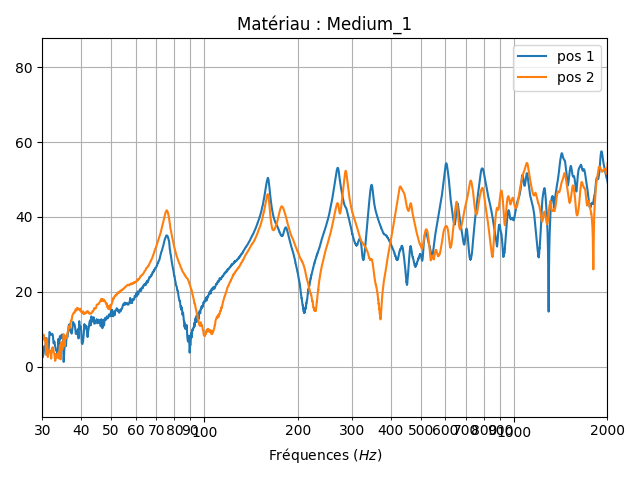

In [13]:
plot_frfs_mat(idx_mat)

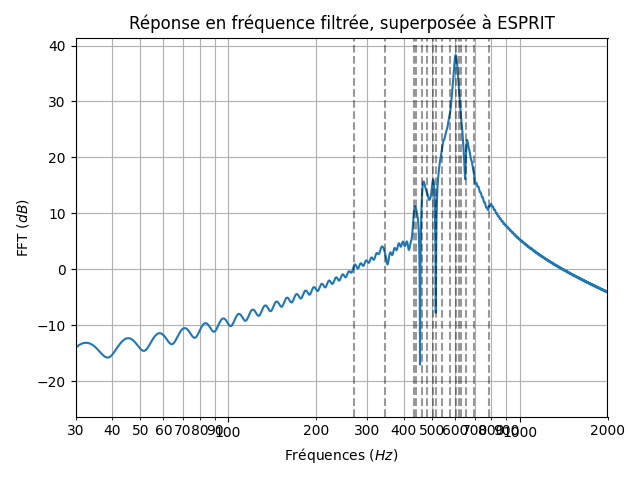

In [14]:
fk, deltak = esprit_on_band(dico_pos1["RI"], dico_pos1["fs"], 450, 650, 32, order=200, plot_result=True, len_esprit=4096, number_of_max=16)
# print(f
# print(deltak)

In [15]:
import pandas as pd

dico = {'fk' : fk,
        'deltak' : deltak}

dicopd = pd.DataFrame(dico)
dicopd



,fk,deltak
0,603.079504,-0.001087
1,617.803808,-0.000710
2,577.338290,-0.000706
3,629.912279,-0.004698
4,540.978755,-0.001351
5,654.146162,-0.000864
6,699.571537,-0.000902
7,503.113530,-0.001128
8,480.150239,0.002286
9,461.990602,-0.000800


In [16]:
import pandas as pd

modal_analysis = {
    "table" : dico_pos1["mat_table"],
   # "freq_metal" : np.array([173,345,378,506,606,711,776,842,889,967,1049,1097,1184]),
    #"freq_plexi" : np.array([72.09741278, 142.14215793, 156.59010082, 236.7269505, 248.2530023, 294.94358678, 337.50039829, 402.02166775, 444.4563055, 480, 496.89932282, 545.17710008, 561.25346576]),
    
    "freq_medium_1" : np.array([75,149,160,184,268,286,319,345,427,460,515,602,654]),
    "xi_medium_1" : np.array([-0.000260,-1.78929982e-04,-0.000337,-0.000808,-0.000549,-0.000603,-0.000752,-0.000908,-0.000219,-0.000758,-0.001235,-0.001077,-0.000958]),
    
    #"freq_medium_2" : np.array([106.97717034, 164.90739819, 189.34747316, 265.9351928, 413.26057931, 425.57839152, 460.04801994, 533.50668071, 604.37383295, 694.37280608, 759.73928757, 817.61882733, 870.98284749])

   # "xi" : np.array([-0.00020138, -0.00021048, -4.5004e-4, -0.00035561, -0.00039229, -1.52620143e-04, -0.00050664, -0.00031898, -0.00036209, -0.00027529, -0.00058368, -0.00082278, -0.00075488]),
}

# modal_analysis["ratios_metal"] = modal_analysis["freq_metal"] / modal_analysis["freq_metal"][0]
# modal_analysis["ratios_plexi"] = modal_analysis["freq_plexi"] / modal_analysis["freq_plexi"][0]
modal_analysis["ratios_medium_1"] = modal_analysis["freq_medium_1"] / modal_analysis["freq_medium_1"][0]
# modal_analysis["ratios_medium_2"] = modal_analysis["freq_medium_2"] / modal_analysis["freq_medium_2"][0]
df_modal_analysis = pd.DataFrame(modal_analysis).T
df_modal_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12
table,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1,Medium_1
freq_medium_1,75,149,160,184,268,286,319,345,427,460,515,602,654
xi_medium_1,-0.00026,-0.000179,-0.000337,-0.000808,-0.000549,-0.000603,-0.000752,-0.000908,-0.000219,-0.000758,-0.001235,-0.001077,-0.000958
ratios_medium_1,1.0,1.986667,2.133333,2.453333,3.573333,3.813333,4.253333,4.6,5.693333,6.133333,6.866667,8.026667,8.72


In [17]:
import pickle
with open('modal_m1.pkl', 'wb') as f:
    pickle.dump(modal_analysis, f)

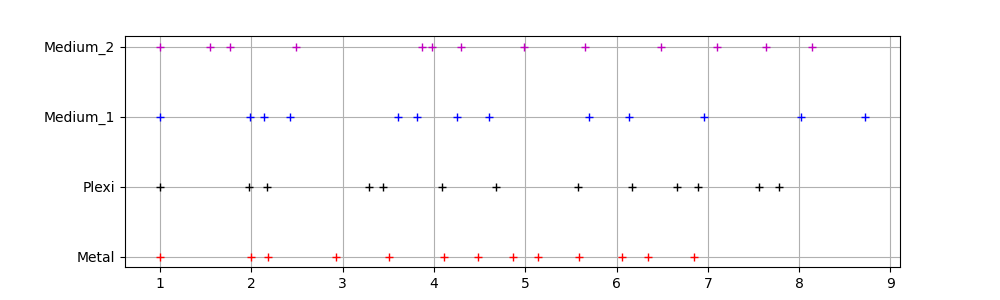

In [50]:
plt.figure(figsize=(10,3))
plt.plot( modal_analysis["ratios_metal"],[0]*13,'r+')
plt.plot(modal_analysis["ratios_plexi"],[1]*13,'k+')
plt.plot(modal_analysis["ratios_medium_1"],[2]*13,'b+')
plt.plot(modal_analysis["ratios_medium_2"],[3]*13,'m+')
plt.yticks([0,1,2,3],['Metal','Plexi','Medium_1','Medium_2'])
plt.grid()
plt.show()